In [1]:
import numpy as np
import pandas as pd
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample.csv")

In [2]:
df_sample = df_sample.reset_index(drop=True)

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['type'])
label
df_sample.drop("type", axis=1, inplace=True)
df_sample["type"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameDest'])
label
df_sample.drop("nameDest", axis=1, inplace=True)
df_sample["nameDest"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameOrig'])
label
df_sample.drop("nameOrig", axis=1, inplace=True)
df_sample["nameOrig"] = label

In [4]:
import pandas as pd

# assuming df is your dataframe
new_order = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type', 'nameDest', 'nameOrig', 'isFraud']

# create a new dataframe with columns in the desired order
df_sample = df_sample.drop(columns=['isFraud']).assign(isFraud=df_sample['isFraud'])

# check that the new dataframe has columns in the desired order
print(df_sample.columns.tolist())

['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type', 'nameDest', 'nameOrig', 'isFraud']


In [5]:
from sklearn.model_selection import train_test_split

X = df_sample.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998743
1    0.001257
Name: isFraud, dtype: float64
0    0.998743
1    0.001257
Name: isFraud, dtype: float64
0    0.998743
1    0.001257
Name: isFraud, dtype: float64


In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=0)

#Downsample via RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.4, random_state=0)

#Application of the resampling methods
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

In [7]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [8]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [9]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [10]:
import random
import numpy as np
from scipy import stats

random.seed(0)
# Specify columns with outliers
cols_with_outliers = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Specify the number of bootstrapped samples to create per column
num_samples = 50

# Specify the right trimming proportions for each column
trim_props = {'amount': 0.01, 'oldbalanceOrg': 0.07, 'newbalanceOrig': 0.015, 'oldbalanceDest': 0.015, 'newbalanceDest': 0.01}

# Initialize empty dictionaries to store the trimmed means for each column
train_trimmed_means = {}

# Loop over the specified columns
for col_name in cols_with_outliers:
    
    # Check if the trimming proportion for this column is 0
    if trim_props[col_name] == 0:
        # If so, skip this column and move on to the next one
        continue
    
    # Initialize empty lists to store the bootstrapped samples and the trimmed means for the training set
    train_bootstrapped_samples = []
    train_trimmed_means_list = []
    
    # Loop over the number of desired samples
    for i in range(num_samples):
        # Randomly select indices from the column in the training set
        train_sample_indices = np.random.choice(X_train_resampled_final.index, size=len(X_train_resampled_final), replace=True)
        
        # Create a bootstrapped sample by indexing into the column with the selected indices for the training set
        train_sample = X_train_resampled_final.loc[train_sample_indices, col_name]
        
        # Append the bootstrapped samples to the list for the training set
        train_bootstrapped_samples.append(train_sample)
        
        # Calculate the right trimmed mean of the bootstrapped sample for the training set
        train_right_trimmed_mean = np.mean(train_sample[train_sample <= np.percentile(train_sample, 100*(1-trim_props[col_name]))])
        train_trimmed_means_list.append(train_right_trimmed_mean)
        
    # Calculate the mean of the right trimmed means for the training set and add it to the dictionary
    train_trimmed_means[col_name] = np.mean(train_trimmed_means_list)

    # Replace the outliers in the training set with the trimmed means
    X_train_resampled_final.loc[X_train_resampled_final[col_name] > np.percentile(X_train_resampled_final[col_name], 100*(1-trim_props[col_name])), col_name] = train_trimmed_means[col_name]
    
    # Replace the outliers in the test set with the trimmed means obtained from the train set
    test_outliers = X_test.loc[X_test[col_name] > np.percentile(X_test[col_name], 100*(1-trim_props[col_name])), col_name]
    X_test.loc[test_outliers.index, col_name] = train_trimmed_means[col_name]
    
# Print the trimmed means for each column separately for the training set
print("Train set trimmed means: ", train_trimmed_means)

Train set trimmed means:  {'amount': 618966.8816921789, 'oldbalanceOrg': 441545.81151241006, 'newbalanceOrig': 458389.1578827894, 'oldbalanceDest': 750209.6643700325, 'newbalanceDest': 1115849.271350117}


In [11]:
# import module
from sklearn.preprocessing import StandardScaler

# compute required values
scaler = StandardScaler()
model = scaler.fit(X_train_resampled_final)
X_train_resampled_final = model.transform(X_train_resampled_final)

model = scaler.fit(X_test)
X_test = model.transform(X_test)

## Implemented autoencoder

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

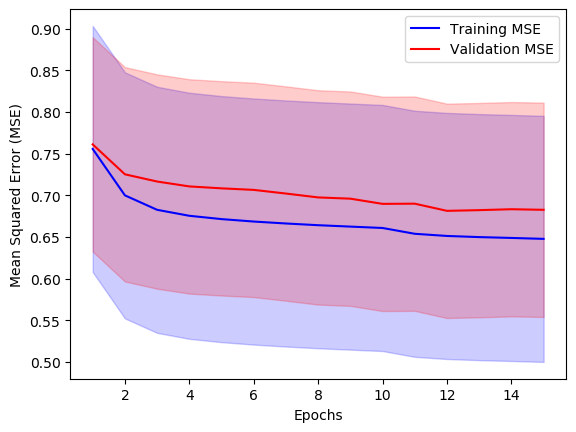

In [13]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 4
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
test_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=15, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)
    
    # Calculate the MSE for the test set
    test_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    test_mse.append(test_error)
    print(f"Test MSE: {test_error:.5f}")

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

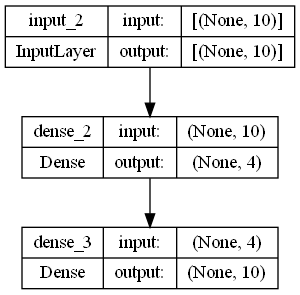

In [14]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder_new.png', show_shapes=True)

In [15]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
 dense_3 (Dense)             (None, 10)                50        
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [16]:
from torchview import draw_graph

batch_size = 2
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(autoencoder, input_size=(batch_size, 32), device='meta')
model_graph.visual_graph

AttributeError: 'Functional' object has no attribute 'training'

In [17]:
import visualkeras
visualkeras.layered_view(autoencoder)

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
# Configure TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model with TensorBoard callback
autoencoder.fit(X_train_resampled_final, X_train_resampled_final,
                epochs=2, batch_size=32,
                validation_data=(X_test, X_test),
                callbacks=[tensorboard_callback])

Epoch 1/2
12765/12765 [==============================] - 55s 4ms/step - loss: 0.6434 - val_loss: 0.5730
Epoch 2/2
12765/12765 [==============================] - 53s 4ms/step - loss: 0.6414 - val_loss: 0.5742


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "C:\Users\23059\anaconda3\envs\test2\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\23059\anaconda3\envs\test2\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\23059\anaconda3\envs\test2\Scripts\tensorboard.exe\__main__.py", line 4, in <module>
  File "C:\Users\23059\anaconda3\envs\test2\lib\site-packages\tensorboard\main.py", line 40, in <module>
    from tensorboard import default
  File "C:\Users\23059\anaconda3\envs\test2\lib\site-packages\tensorboard\default.py", line 39, in <module>
    from tensorboard.plugins.beholder import beholder_plugin_loader
  File "C:\Users\23059\anaconda3\envs\test2\lib\site-packages\tensorboard\plugins\beholder\__init__.py", line 22, in <module>
    from tensorboard.plugins.beholder.beholder import Beholder
  File "C:\Users\23059\anaconda3\envs\test2\lib\site-pack

In [24]:
# Launch TensorBoard
%load_ext tensorboard
%tensorboard --logdir=./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 14452.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

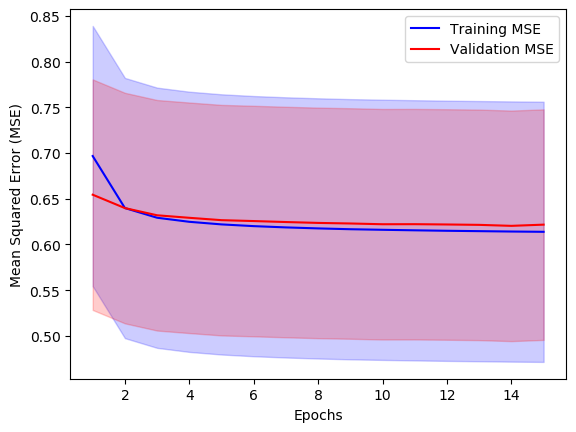

In [26]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 50
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
test_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=15, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)
    
    # Calculate the MSE for the test set
    test_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    test_mse.append(test_error)
    print(f"Test MSE: {test_error:.5f}")

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

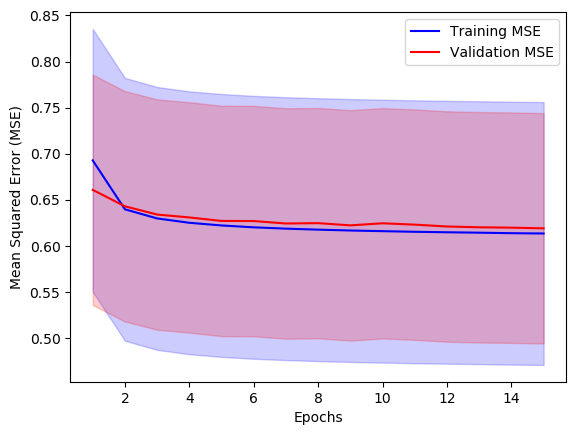

In [27]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 25
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00087)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
test_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=15, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)
    
    # Calculate the MSE for the test set
    test_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    test_mse.append(test_error)
    print(f"Test MSE: {test_error:.5f}")

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

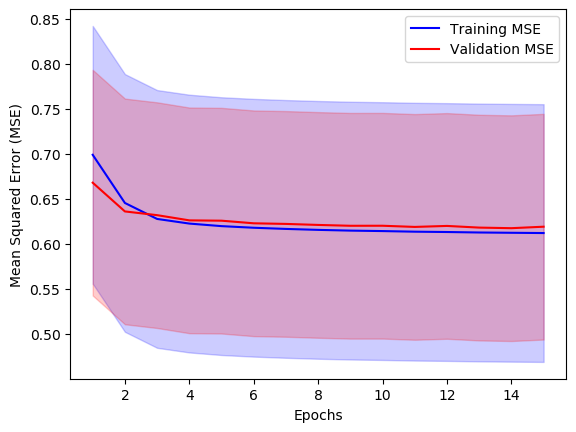

In [28]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 30
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00099)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
test_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=15, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)
    
    # Calculate the MSE for the test set
    test_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    test_mse.append(test_error)
    print(f"Test MSE: {test_error:.5f}")

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

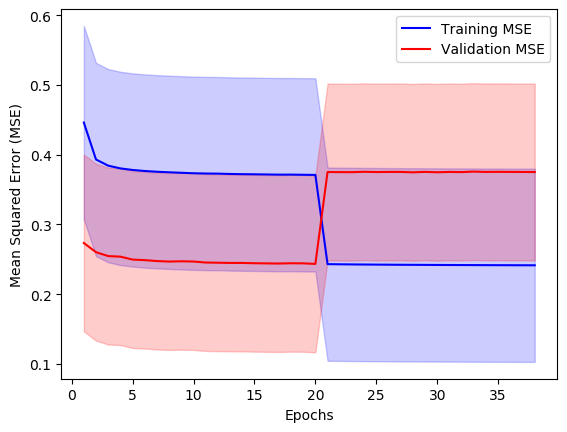

In [32]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
# Set random seed for reproducibility
np.random.seed(42)

# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 30
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.00991))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.00099)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
test_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=20, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)
    
    # Calculate the MSE for the test set
    test_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    test_mse.append(test_error)
    print(f"Test MSE: {test_error:.5f}")

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

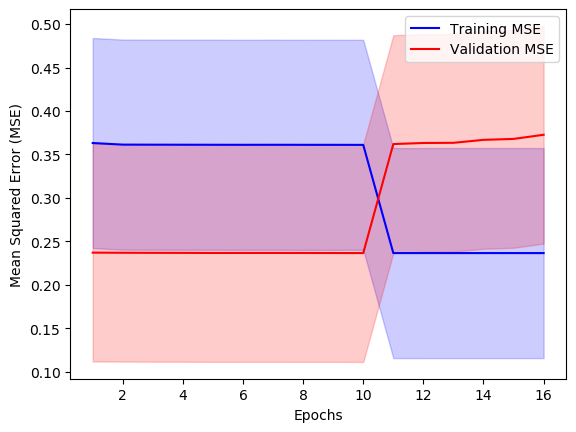

In [33]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
np.random.seed(42)
# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 30
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate
#opt = Adam(lr= 0.00874103303583597)
opt = Adam(lr= 0.00874103303583597)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# # plot the distribution of reconstruction errors
# plt.hist(recon_errors, bins=5)
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Distribution of Reconstruction Errors')
# plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

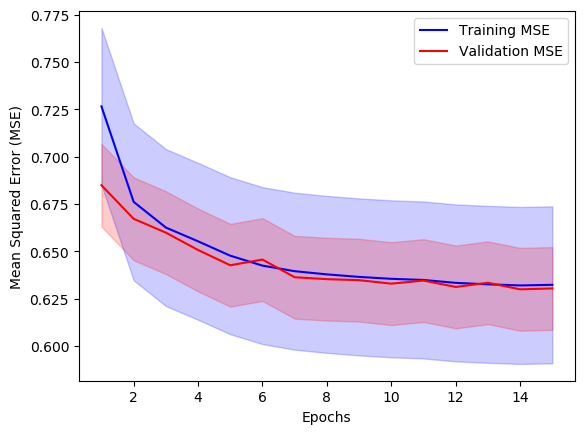

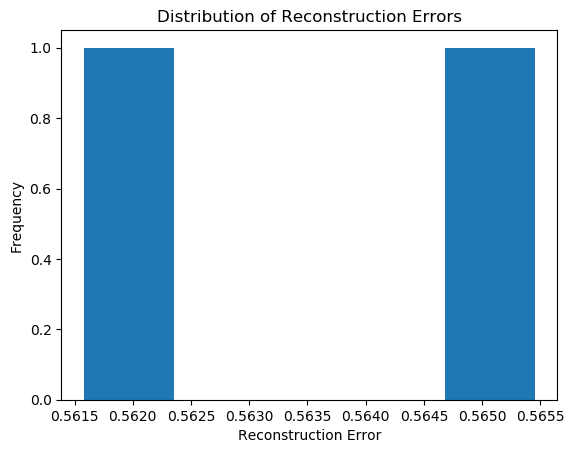

In [34]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
np.random.seed(42)
# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 40
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.025))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.002)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=15, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

In [37]:
#FOR THE CODE JUST ABOVE

test_error = autoencoder.evaluate(X_test, X_test, verbose=0)
test_mse.append(test_error)
print(f"Test MSE: {test_error:.5f}")

Test MSE: 0.56158


In [ ]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
np.random.seed(42)
# Define the autoencoder architecture
input_dim = X_train_resampled_final.shape[1]
encoding_dim = 40
decoding_dim = 10

input_layer = Input(shape=(input_dim,))
#hidden_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Add L1 regularization to the hidden layer
hidden_layer = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1(0.01))(input_layer)

output_layer = Dense(decoding_dim, activation='sigmoid')(hidden_layer)

# Define the optimizer with the desired learning rate

opt = Adam(lr= 0.002)
# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=opt, loss='mse')

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits)

# Define lists to store the MSE of training and validation sets for each fold
train_mse = []
val_mse = []
recon_errors = []


# Loop over each fold
for train_index, val_index in kf.split(X_train_resampled_final):
    
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_resampled_final[train_index], X_train_resampled_final[val_index]
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Fit the autoencoder on the training set for the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold, epochs=15, batch_size=32, verbose=0, validation_data=(X_val_fold, X_val_fold),callbacks=[early_stopping])
    
    # Append the MSE of training and validation sets for the current fold to the lists
    train_mse.append(history.history['loss'])
    val_mse.append(history.history['val_loss'])
    
    # compute the reconstruction error for the test data
    recon_error = autoencoder.evaluate(X_test, X_test, verbose=0)
    recon_errors.append(recon_error)

# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
# mean_train_mse = np.mean(train_mse, axis=0)
# std_train_mse = np.std(train_mse, axis=0)
# mean_val_mse = np.mean(val_mse, axis=0)
# std_val_mse = np.std(val_mse, axis=0)
# Calculate the mean and standard deviation of MSE for training and validation sets across all folds
mean_train_mse = np.mean(train_mse, axis=0)
#std_train_mse = np.std(np.array(train_mse), axis=0)
std_train_mse = np.std(np.concatenate(train_mse), axis=0)

mean_val_mse = np.mean(val_mse, axis=0)
#std_val_mse = np.std(np.array(val_mse), axis=0)
std_val_mse = np.std(np.concatenate(val_mse), axis=0)


# Plot the MSE of training and validation sets against the number of epochs
epochs = range(1, len(mean_train_mse)+1)
plt.plot(epochs, mean_train_mse, 'b', label='Training MSE')
plt.fill_between(epochs, mean_train_mse - std_train_mse, mean_train_mse + std_train_mse, alpha=0.2, color='b')
plt.plot(epochs, mean_val_mse, 'r', label='Validation MSE')
plt.fill_between(epochs, mean_val_mse - std_val_mse, mean_val_mse + std_val_mse, alpha=0.2, color='r')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

# plot the distribution of reconstruction errors
plt.hist(recon_errors, bins=5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set